## THE MODELS 

1. Stock data forecasts and models
   
   1. ets model 
   2. linear regression model
   3. arima model


#### How it works:

    - User will input the number of stocks they want to see 
    - User will then input respective ticker symbols 
    - See model results
  

In [161]:
# import libraries 

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller 
import pmdarima as pm


In [162]:
# get the dataset and prepare it function

def get_and_prep_dataset(list_of_tickers, call_num):

    # get ticker symbol from list of tickers from user
    set_ticker = list_of_tickers[call_num]

    # get ticker from Yahoo Finance API
    ticker = yf.Ticker(set_ticker)

    # get historical data - 5yr range 
    from_yahoo = ticker.history(period = '5y')

    # set raw_dataset variable 
    raw_dataset = from_yahoo

    # series holding opening prices
    df_op = raw_dataset['Open']

    # series holding closing prices
    df_ser = raw_dataset['Close']
    
    # series holding volume
    df_volume_ser = raw_dataset['Volume']

    # convert series to pandas dataframes 
    df_ = pd.DataFrame(df_op)
    df_.index.name = None # fix for the two rows for column header issue
    df_.reset_index(level = 0, inplace = True)
    df_.rename(columns = {'index' : 'Date'}, inplace = True)

    df = pd.DataFrame(df_ser)
    df.index.name = None # fix for the two rows for column header issue
    df.reset_index(level = 0, inplace = True)
    df.rename(columns = {'index' : 'Date'}, inplace = True)

    df_volume = pd.DataFrame(df_volume_ser)
    df_volume.index.name = None # fix for the two rows for column header issue
    df_volume.reset_index(level = 0, inplace = True)
    df_volume.rename(columns = {'index' : 'Date'}, inplace = True)

    # set name variable from dictionary of company info
    name = ticker.info['longName']

    # set ticker symbol variable from dictionary of company info
    ticker_symbol = ticker.info['symbol']

    return df_, df, df_volume, name, ticker_symbol, ticker, raw_dataset
    

##### 1. ets model

    - Forecasts opening price for the next 14 records

In [163]:
# EDA 

def see_data(df_):

    # see missing data, if any
    print('Number of missing data records from Open: ' + str(sum(df_['Open'].isna())))
    print('Number of missing data records from Date: ' + str(sum(df_['Date'].isna())))

    print('\n')

    # see info
    print(df_.info())
    

In [164]:
# secondary plots - in matplotlib 

def secondary_visualizations(df_, ticker):
    
    # constructing the visualisation
    plt.figure(figsize = (15, 8))

    plt.plot(df_['Date'], df_['Open'], label = 'Open Price History')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Open Price ($)')
    
    plt.show()
    

In [165]:
# the ets model 

def the_etsmodel(df_):

    open_price = df_['Open'].values.tolist()

    dte = df_['Date'].dt.strftime('%m-%d-%Y')
    dte = dte.values.tolist()

    price = pd.Series(open_price, index = dte)

    model = ETSModel(price, error = 'add', trend = 'add', seasonal = None, damped_trend = True)
    
    fit = model.fit()

    print(fit.summary())

    # model's fit 
    plt.figure(figsize = (10, 6))
    plt.title('Fit against the data')
    price.plot(label = 'original', color = 'black', linestyle = 'solid')
    fit.fittedvalues.plot(label = 'model fit', linestyle = 'dotted', color = 'orange')
    plt.xlabel('Date')
    plt.ylabel('Open Price ($)')
    plt.legend()
    plt.show()

    # prediction range - next 14 records
    start_rec = len(price)
    end_rec = start_rec + 14

    forecast = fit.get_prediction(start = start_rec, end = end_rec)

    fc_result = forecast.summary_frame(alpha = 0.05)

    display(fc_result)

    plt.figure(figsize = (10, 6))
    plt.title('Forecasts')
    fc_result['mean'].plot(label = 'mean', color = 'red')
    fc_result['pi_lower'].plot(label = '95% prediction interval (lower band)', linestyle = 'dotted', color = 'blue')
    fc_result['pi_upper'].plot(label = '95% prediction interval (upper band)', linestyle = 'dotted', color = 'blue')
    price.plot(label = 'original', linestyle = 'solid', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Open Price ($)')
    plt.legend()
    plt.show()


##### 2. linear regression model

    - predicts closing price for the next trading day based on historical opening price 

In [166]:
# EDA 

def see_data_lr(raw_dataset, df_):

    # see missing data, if any
    print('Number of missing data records from Open: ' + str(sum(raw_dataset['Open'].isna())))
    print('Number of missing data records from Close: ' + str(sum(raw_dataset['Close'].isna())))
    print('Number of missing data records from Date: ' + str(sum(df_['Date'].isna())))

    print('\n')

    # see info
    print(raw_dataset.info())
    

In [167]:
# secondary plots - in matplotlib 

def secondary_visualizations_lr(raw_dataset, df_, ticker):
    
    # constructing the visualisation
    plt.figure(figsize = (15, 8))

    plt.plot(df_['Date'], raw_dataset['Open'], label = 'Open Price History')
    plt.plot(df_['Date'], raw_dataset['Close'], label = 'Close Price History')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    
    plt.show()
    

In [168]:
# the linear regression model 

def lreg_model(raw_dataset, ticker):

    X = raw_dataset['Open']
    y = raw_dataset['Close']

    X = X.values.tolist()
    y = y.values.tolist()

    X = np.array(X)
    y = np.array(y)

    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    mod = LinearRegression()
    mod.fit(X, y)

    prompt_res = []
    prompt = input('YES/NO: Do you know the opening price for {} from the previous trading day? '.format(str(ticker.info['symbol'])))
    prompt_res.append(prompt.upper())

    if prompt_res[0] == 'YES':
        prompt2 = input('Enter the opening price for {} from the previous trading day (without the $): '.format(str(ticker.info['symbol'])))
        X_fc = [prompt2]
    else:
        X_fc = [raw_dataset['Close'].iloc[-10].mean()]

    X_fc = np.array(X_fc)
    X_fc = X_fc.reshape(-1, 1)

    y_fc = mod.predict(X_fc)

    predicted_price = y_fc.flat[0]

    # prediction
    print('Predicted Closing Price for {} -> ${}'.format(str(ticker.info['longName']), round(predicted_price, 4)))

    XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size = 0.20)

    mmodel = LinearRegression()

    mmodel.fit(XX_train, yy_train)

    y_pr = mmodel.predict(XX_test)

    # evaluation
    r2 = r2_score(yy_test, y_pr)
    mae = mean_absolute_error(yy_test, y_pr)
    itcept = mmodel.intercept_.flat[0]
    coef = mmodel.coef_.flat[0]

    print('\n')
    print('Closing Price = {} + {} * Opening Price'.format(round(itcept, 4), round(coef, 4)))
    print('The R^2: {}'.format(round(r2, 4)))
    print('The MAE: {}'.format(round(mae, 4)))

    plt.figure(figsize = (15, 8))

    plt.scatter(XX_test, yy_test, color = 'red', label = 'observed values')
    plt.plot(XX_test, y_pr, label = 'predicted values')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Price ($)')
    plt.ylabel('Price ($)')
    plt.legend()
    
    plt.show()
    

#### 3. arima model

In [169]:
# EDA

def see_data_ar(df):

    # see missing data, if any
    print('Number of missing data records from Open: ' + str(sum(df['Close'].isna())))
    print('Number of missing data records from Date: ' + str(sum(df['Date'].isna())))

    print('\n')

    # see info
    print(df.info())
    

In [170]:
# secondary plots - in matplotlib 

def secondary_visualizations_ar(df, ticker):
    
    # constructing the visualisation
    plt.figure(figsize = (15, 8))
    plt.plot(df['Date'], df['Close'], label = 'Close Price History')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Close Price ($)')
    plt.show()
    

In [171]:
# the arima model

def the_arima(df):

    # stationarity test
    test_results = adfuller(df['Close'])
    
    print('The null hypothesis (H0) is the data is NOT stationary')
    print('\n')
    print('p-value = {}'.format(round(test_results[1], 4)))
    print('lags used = {}'.format(test_results[2]))
    print('num of obs = {}'.format(test_results[3]))
    print('\n')

    if test_results[1] <= 0.05:
        print('There is significant evidence against the null, as a result H0 is rejected and the data is stationary')
        print('\n')
        stationary_data = df['Close'].dropna()
    else:
        print('There is not enough evidence to reject the null and the data is NOT stationary')
        print('\n')
        df['Close 1st Diff'] = df['Close'] - df['Close'].shift(1)
        df['Close Seasonal Diff'] = df['Close'] - df['Close'].shift(12)

        test_results_sea = adfuller(df['Close Seasonal Diff'].dropna())

        print('p-value = {}'.format(round(test_results_sea[1], 4)))
        print('lags used = {}'.format(test_results_sea[2]))
        print('num of obs = {}'.format(test_results_sea[3]))
        print('\n')

        if test_results_sea[1] <= 0.05: 
            print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
            print('\n')
            stationary_data = df['Close Seasonal Diff'].dropna()
        else:
            print('There is not enough evidence to reject the null and the data is NOT stationary')
            print('\n')
            
            test_results_1st = adfuller(df['Close 1st Diff'].dropna())

            print('p-value = {}'.format(round(test_results_1st[1], 4)))
            print('lags used = {}'.format(test_results_1st[2]))
            print('num of obs = {}'.format(test_results_1st[3]))
            print('\n')

            if test_results_1st[1] <= 0.05: 
                print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
                print('\n')
                stationary_data = df['Close 1st Diff'].dropna()
            else:
                print('There is not enough evidence to reject the null and the data is NOT stationary')
                print('\n')

                test_results_sea = adfuller(df['Close Seasonal Diff'].dropna())

                print('p-value = {}'.format(round(test_results_sea[1], 4)))
                print('lags used = {}'.format(test_results_sea[2]))
                print('num of obs = {}'.format(test_results_sea[3]))
                print('\n')

                if test_results_sea[1] <= 0.05: 
                    print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
                    print('\n')
                    stationary_data = df['Close Seasonal Diff'].dropna()
                else:
                    print('There is not enough evidence to reject the null and the data is NOT stationary')
                    print('\n')

                    test_results_1st = adfuller(df['Close 1st Diff'].dropna())

                    print('p-value = {}'.format(round(test_results_1st[1], 4)))
                    print('lags used = {}'.format(test_results_1st[2]))
                    print('num of obs = {}'.format(test_results_1st[3]))
                    print('\n')

                    if test_results_1st[1] <= 0.05:
                        print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
                        print('\n')
                        stationary_data = df['Close 1st Diff'].dropna()
                    else:
                        print('Exceeded the recommended number of differencing')
                        print('\n')
                        quit()
                        
    # arima model 
    model = pm.auto_arima(stationary_data, error_action = 'ignore', suppress_warnings = True, stepwise = False)
    
    display(model.summary())

    model.plot_diagnostics(figsize = (10, 6))
    plt.show()

    model.fit(stationary_data)

    forecast = model.predict(n_periods = 12, return_conf_int = True) 

    forecast_ser = pd.Series(forecast)

    display(forecast_ser)
    

The tool will be run for 3 stock/s
The stock/s -> ['MSFT', 'VUG', 'RKLB']


Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Open    1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


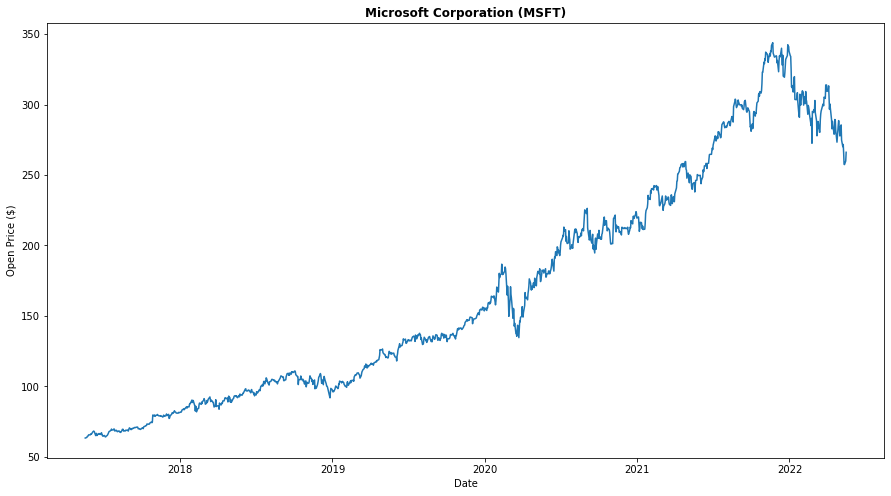

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                 1259
Model:                      ETS(AAdN)   Log Likelihood               -3251.158
Date:                Wed, 18 May 2022   AIC                           6514.316
Time:                        14:37:35   BIC                           6545.144
Sample:                             0   HQIC                          6525.901
                               - 1259   Scale                           10.245
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9007      0.029     31.237      0.000       0.844       0.957
smoothing_trend  9.007e-05        nan        nan        nan         nan         nan
damping_trend       0.9102      

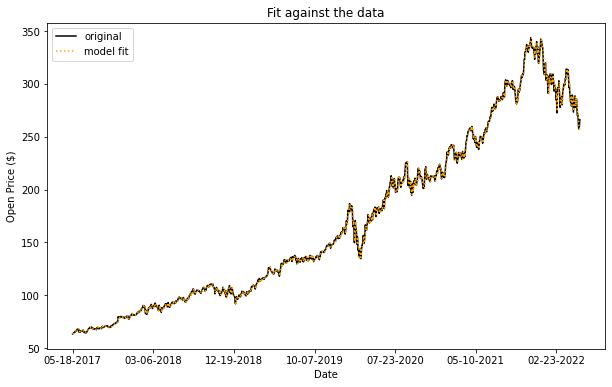

,mean,pi_lower,pi_upper
1259,265.473547,259.200131,271.746963
1260,265.472672,257.029391,273.915953
1261,265.471876,255.311780,275.631971
1262,265.471151,253.844849,277.097453
1263,265.470492,252.543054,278.397929
1264,265.469891,251.360661,279.579122
1265,265.469345,250.269814,280.668876
1266,265.468847,249.252053,281.685642
1267,265.468395,248.294400,282.642390
1268,265.467983,247.387316,283.548650


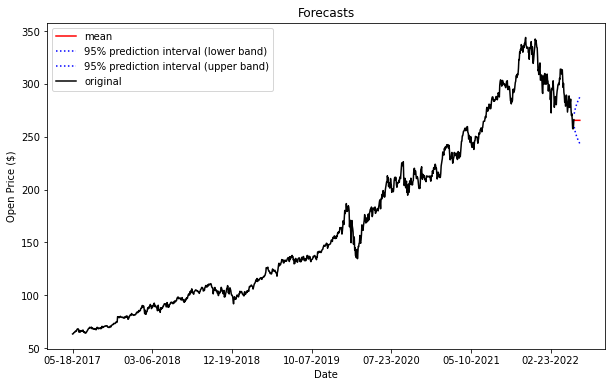

 
Number of missing data records from Open: 0
Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-05-18 to 2022-05-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 78.7 KB
None


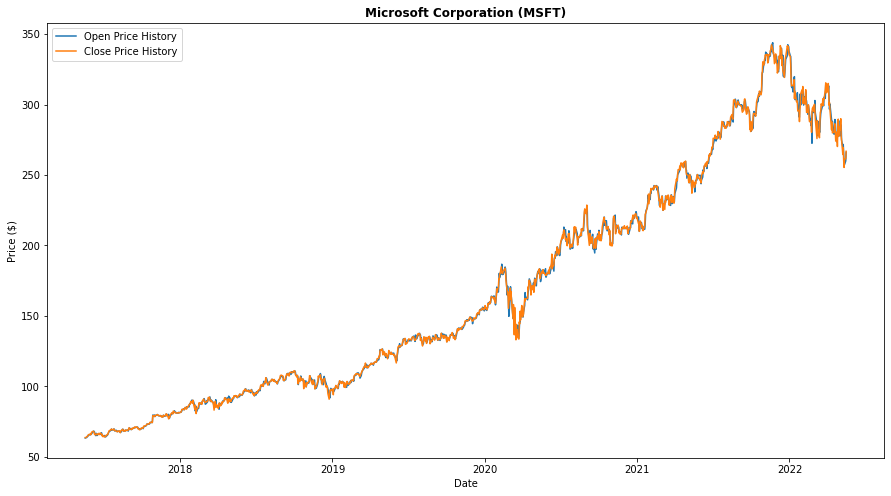

Predicted Closing Price for Microsoft Corporation -> $289.8951


Closing Price = 0.2171 + 0.9989 * Opening Price
The R^2: 0.9987
The MAE: 1.8159


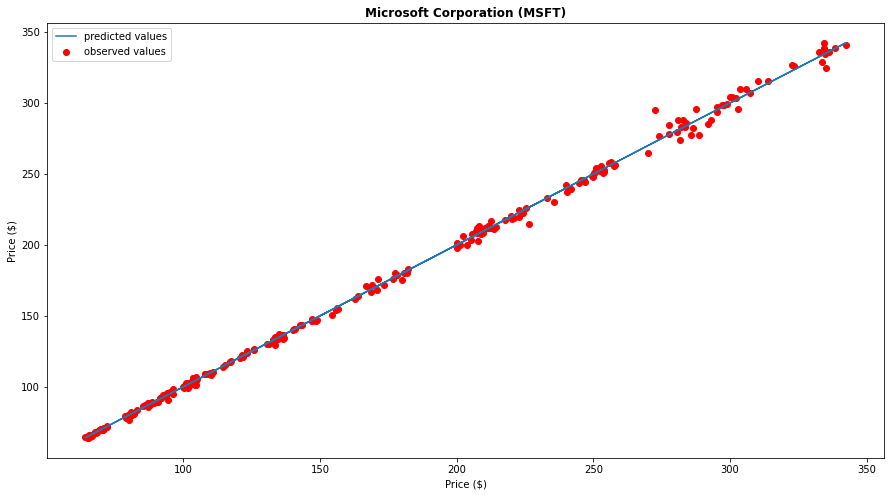

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Close   1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


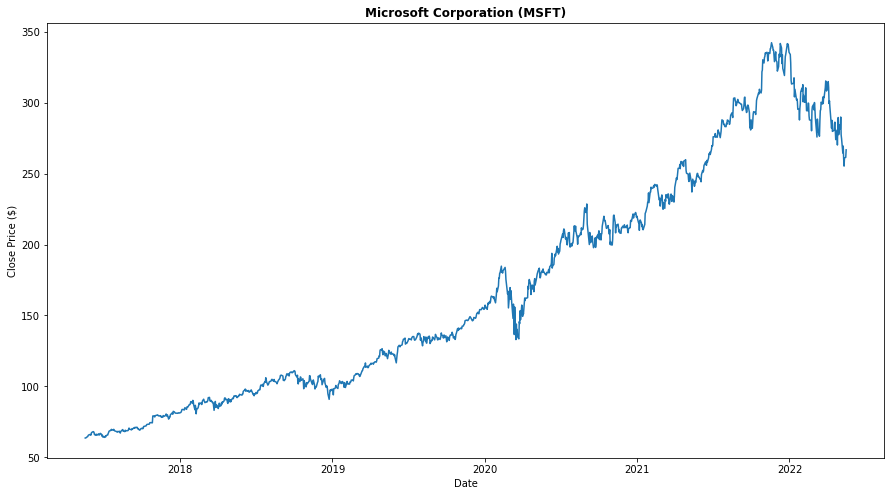

The null hypothesis (H0) is the data is NOT stationary


p-value = 0.8439
lags used = 9
num of obs = 1249


There is not enough evidence to reject the null and the data is NOT stationary


p-value = 0.0
lags used = 23
num of obs = 1223


There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary




<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1247
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -3603.237
Date:                Wed, 18 May 2022   AIC                           7220.474
Time:                        14:37:53   BIC                           7256.373
Sample:                             0   HQIC                          7233.971
                               - 1247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2274      0.412      2.981      0.003       0.421       2.034
ar.L1         -0.7813      0.047    -16.454      0.000      -0.874      -0.688
ar.L2          0.7819      0.014     55.677      0.000       0.754       0.809
ar.L3          0.6650      0.038     17.466      0.000       0.590       0.740
ma.L1          1.6085      0.056     28.787      0.000       1.499       1.718
ma.L2          0.6187      0.055     11.191      0.000       0.510       0.727
sigma2        18.8846      0.491     38.455      0.000      17.922      19.847
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):               439.20
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               9.07   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

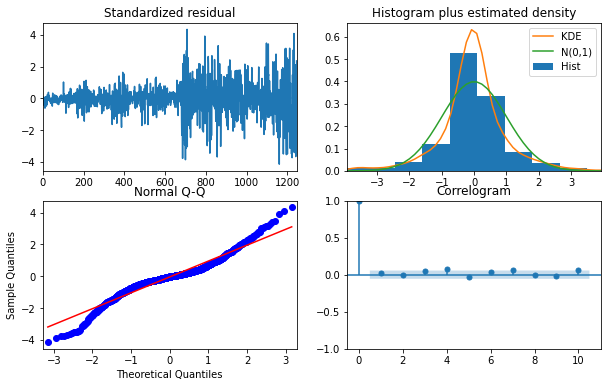

0    [-14.721596308725774, -8.007488133925406, -11....
1    [[-23.238892869606858, -6.204299747844692], [-...
dtype: object

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Open    1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


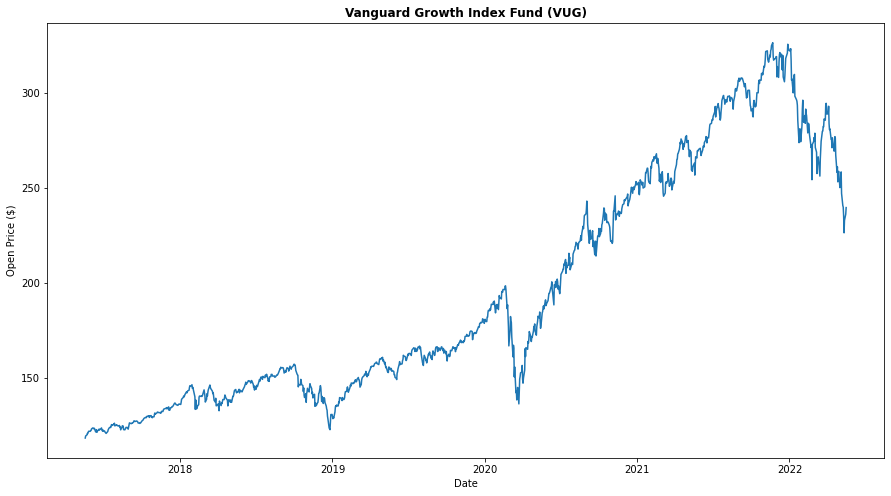

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                 1259
Model:                      ETS(AAdN)   Log Likelihood               -3136.749
Date:                Wed, 18 May 2022   AIC                           6285.498
Time:                        14:38:02   BIC                           6316.327
Sample:                             0   HQIC                          6297.084
                               - 1259   Scale                            8.542
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9160      0.033     27.870      0.000       0.852       0.980
smoothing_trend     0.0030      0.018      0.170      0.865      -0.032       0.038
damping_trend       0.8950      

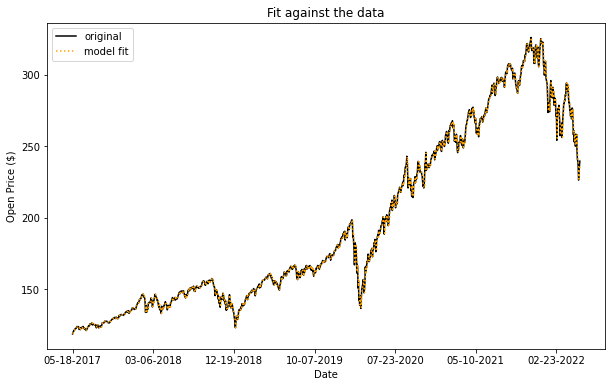

,mean,pi_lower,pi_upper
1259,239.210539,233.482069,244.939008
1260,239.186497,231.407350,246.965644
1261,239.164979,229.764857,248.565101
1262,239.145719,228.359537,249.931901
1263,239.128482,227.110171,251.146792
1264,239.113053,225.973637,252.252469
1265,239.099244,224.923768,253.274720
1266,239.086885,223.943255,254.230514
1267,239.075822,223.019934,255.131711
1268,239.065921,222.144860,255.986983


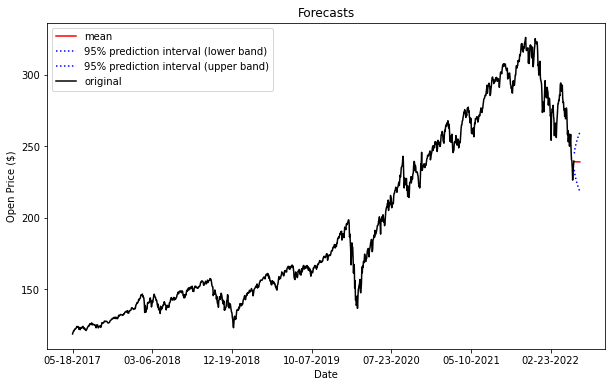

 
Number of missing data records from Open: 0
Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-05-18 to 2022-05-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 78.7 KB
None


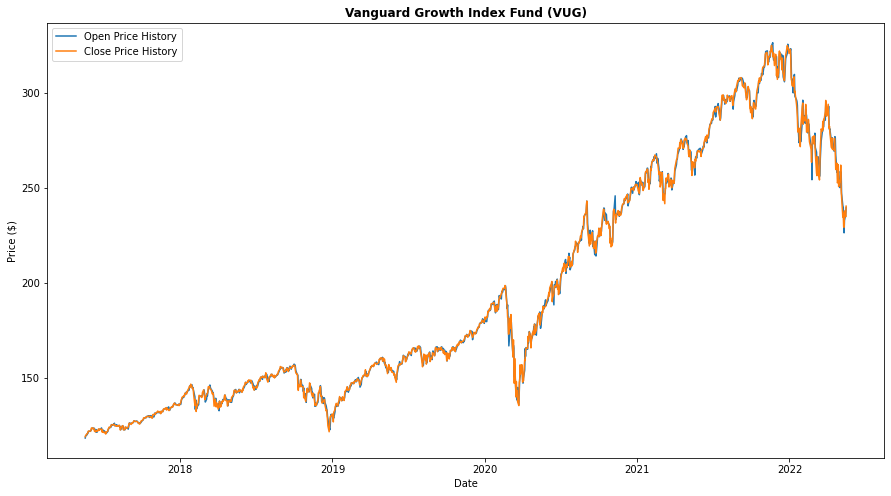

Predicted Closing Price for Vanguard Growth Index Fund -> $261.7422


Closing Price = 0.3205 + 0.9982 * Opening Price
The R^2: 0.9987
The MAE: 1.4066


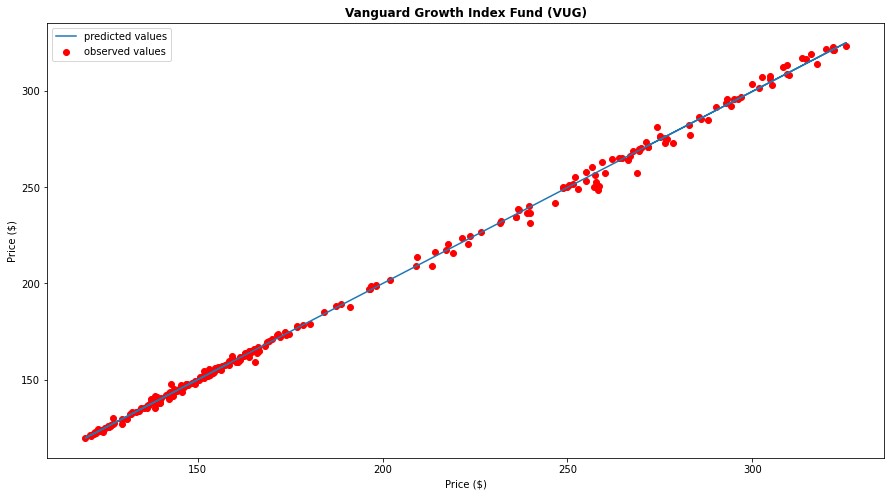

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Close   1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


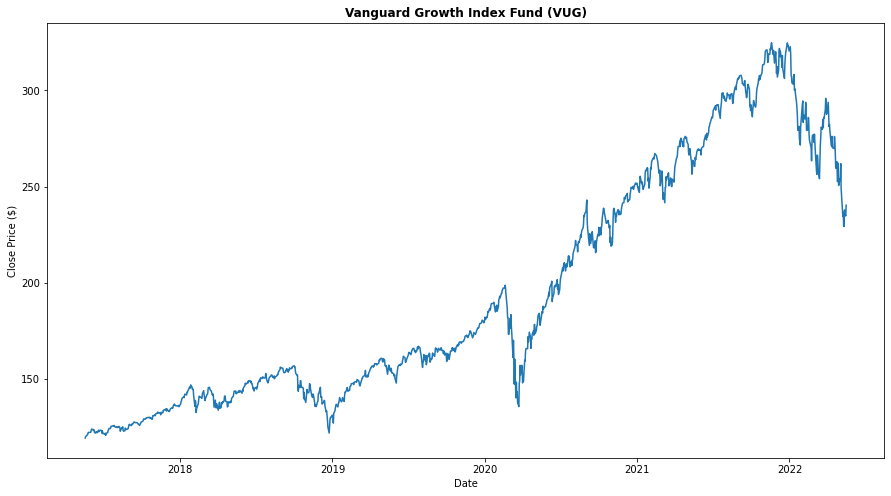

The null hypothesis (H0) is the data is NOT stationary


p-value = 0.7093
lags used = 15
num of obs = 1243


There is not enough evidence to reject the null and the data is NOT stationary


p-value = 0.0
lags used = 21
num of obs = 1225


There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary




<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1247
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -3431.940
Date:                Wed, 18 May 2022   AIC                           6877.881
Time:                        14:38:22   BIC                           6913.780
Sample:                             0   HQIC                          6891.378
                               - 1247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1473      0.378      0.390      0.696      -0.593       0.887
ar.L1         -0.8046      0.041    -19.399      0.000      -0.886      -0.723
ar.L2          0.8006      0.013     63.421      0.000       0.776       0.825
ar.L3          0.7119      0.035     20.612      0.000       0.644       0.780
ma.L1          1.6765      0.049     33.924      0.000       1.580       1.773
ma.L2          0.6913      0.049     14.072      0.000       0.595       0.788
sigma2        14.2355      0.380     37.420      0.000      13.490      14.981
===================================================================================
Ljung-Box (L1) (Q):                   3.03   Jarque-Bera (JB):               420.88
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               6.88   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

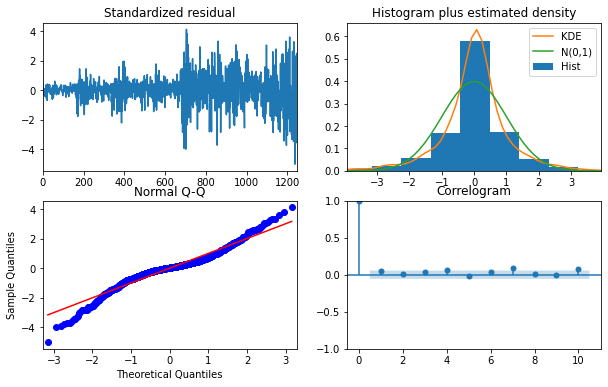

0    [-14.932584483702044, -9.026896880108042, -11....
1    [[-22.327510081409333, -7.537658885994754], [-...
dtype: object

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    372 non-null    datetime64[ns]
 1   Open    372 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.9 KB
None


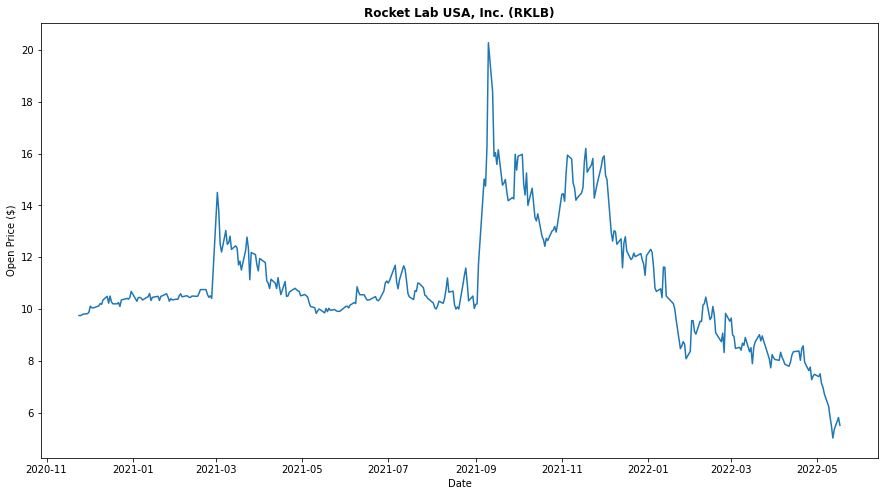

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  372
Model:                      ETS(AAdN)   Log Likelihood                -315.583
Date:                Wed, 18 May 2022   AIC                            643.166
Time:                        14:38:32   BIC                            666.680
Sample:                             0   HQIC                           652.504
                                - 372   Scale                            0.319
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.061     16.286      0.000       0.880       1.120
smoothing_trend  9.999e-05        nan        nan        nan         nan         nan
damping_trend       0.9757      

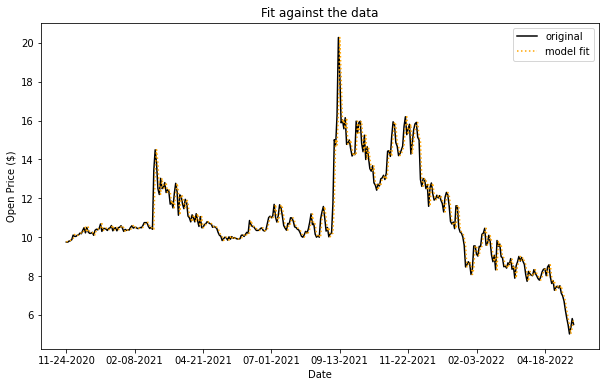

,mean,pi_lower,pi_upper
372,5.509744,4.401996,6.617492
373,5.509464,3.942874,7.076055
374,5.509191,3.590458,7.427925
375,5.508925,3.293276,7.724574
376,5.508665,3.031392,7.985939
377,5.508412,2.794580,8.222244
378,5.508165,2.576766,8.439563
379,5.507923,2.373993,8.641853
380,5.507688,2.183513,8.831863
381,5.507458,2.003324,9.011592


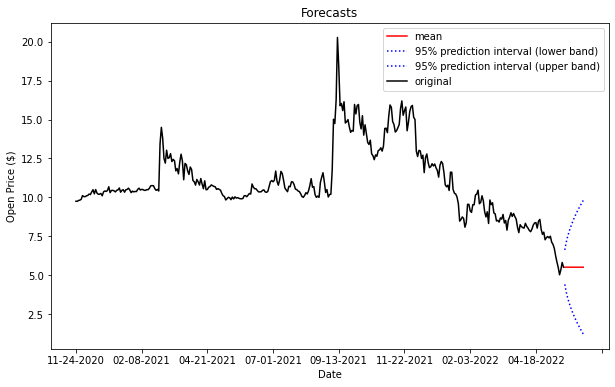

 
Number of missing data records from Open: 0
Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372 entries, 2020-11-24 to 2022-05-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          372 non-null    float64
 1   High          372 non-null    float64
 2   Low           372 non-null    float64
 3   Close         372 non-null    float64
 4   Volume        372 non-null    int64  
 5   Dividends     372 non-null    int64  
 6   Stock Splits  372 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 23.2 KB
None


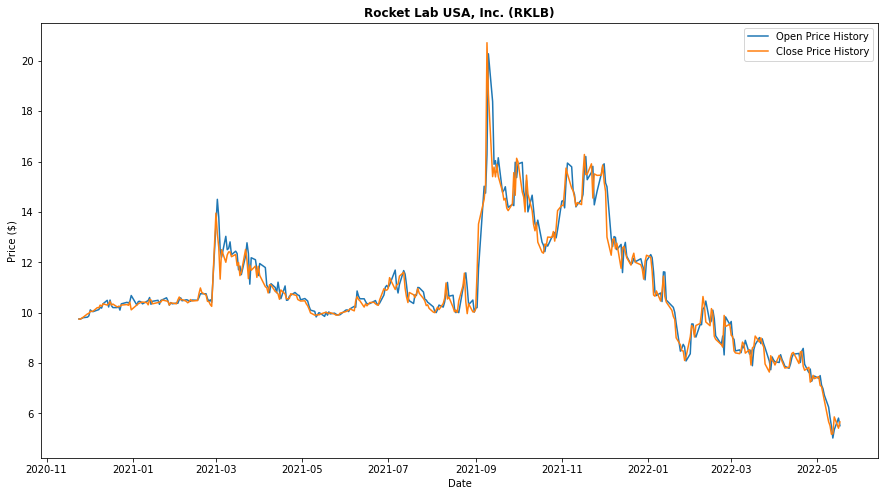

Predicted Closing Price for Rocket Lab USA, Inc. -> $7.1159


Closing Price = 0.2557 + 0.9695 * Opening Price
The R^2: 0.9396
The MAE: 0.3394


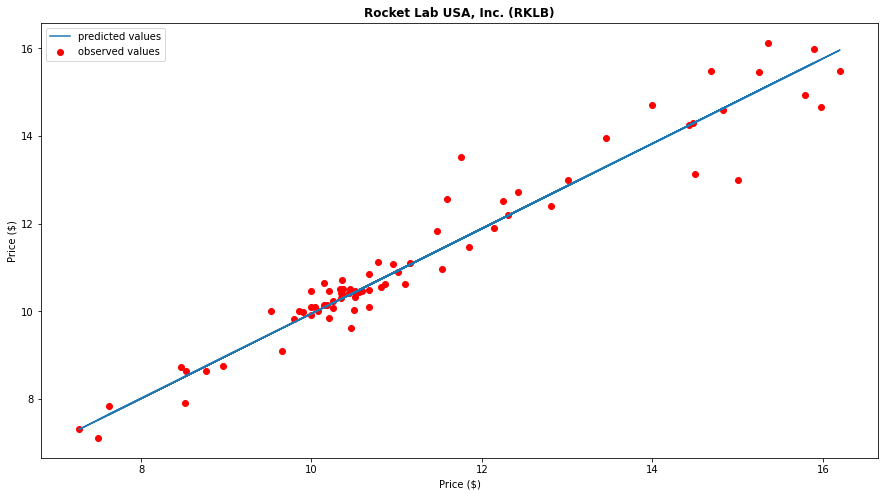

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    372 non-null    datetime64[ns]
 1   Close   372 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.9 KB
None


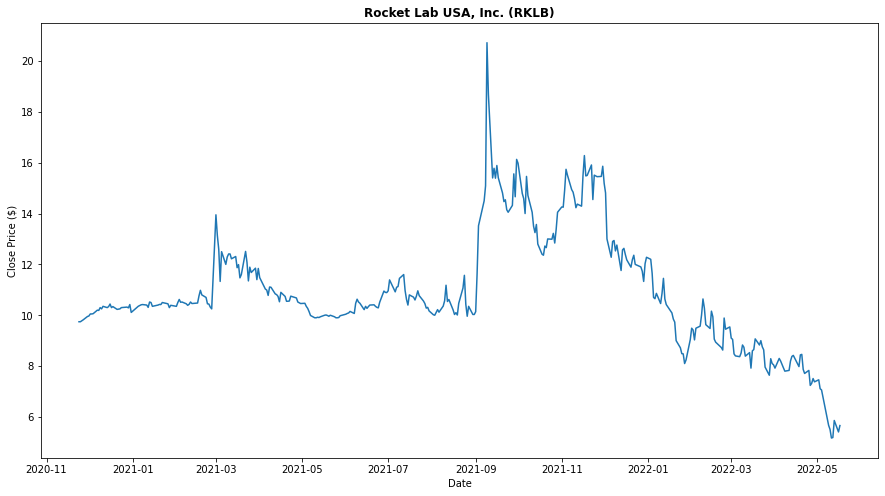

The null hypothesis (H0) is the data is NOT stationary


p-value = 0.513
lags used = 2
num of obs = 369


There is not enough evidence to reject the null and the data is NOT stationary


p-value = 0.0069
lags used = 15
num of obs = 344


There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary




<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -432.310
Date:                Wed, 18 May 2022   AIC                            870.621
Time:                        14:39:10   BIC                            882.279
Sample:                             0   HQIC                           875.256
                                - 360                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0199      0.043     -0.467      0.641      -0.103       0.064
ar.L1          0.8626      0.017     49.562      0.000       0.828       0.897
sigma2         0.6441      0.019     34.775      0.000       0.608       0.680
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):              3097.11
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                        17.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

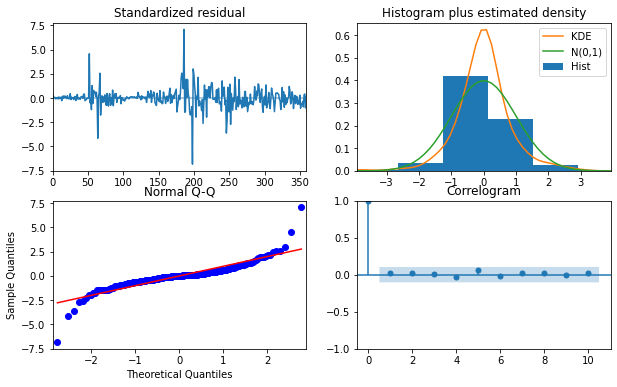

0    [-1.5035590219251334, -1.316857797000579, -1.1...
1    [[-3.0765018513210434, 0.06938380747077666], [...
dtype: object

In [172]:
# all calls and input requests for the user

# user enters number of stocks to see 
how_many = input('Enter how many stocks: ')

# creates an array that will hold user input for ticker symbols 
list_of_tickers = []
for h in range(int(how_many)):
    input_ticker = input('Enter ticker symbol: ')
    list_of_tickers.append(input_ticker.upper())

# presentation info
print('The tool will be run for ' + str(how_many) + ' stock/s')
print('The stock/s -> ' + str(list_of_tickers))
print('\n')

# function calls 
for call_num in range(len(list_of_tickers)):
    df_, df, df_volume, name, ticker_symbol, ticker, raw_dataset = get_and_prep_dataset(list_of_tickers = list_of_tickers, call_num = call_num)

    # ets model
    see_data(df_)
    secondary_visualizations(df_, ticker)    
    the_etsmodel(df_)
    print(' ')

    # linear regression model
    see_data_lr(raw_dataset, df_)    
    secondary_visualizations_lr(raw_dataset, df_, ticker)
    lreg_model(raw_dataset, ticker)
    print(' ')

    # arima model
    see_data_ar(df)
    secondary_visualizations_ar(df, ticker)
    the_arima(df)
    print(' ')
